# 프로젝트명 : Movielens 영화 SBR
Movielens 1M dataset을 기반으로, Session based Recommendation 시스템 제작하기

### 루브릭

|순번|평가문항|상세기준|
|:---|:---|:-------|
|1|Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
|2|RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
|3|세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.|3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|

## 데이터 준비

In [1]:
# 필요한 라이브러리 불러오기
import datetime as dt
from pathlib import Path  # pathlib 라이브러리 참고
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/exploration/E12/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### 특기사항

- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.


- Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.


- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

## 데이터 전처리

In [3]:
print('User ID 수: ', data['UserId'].nunique())
print('영화 개수: ', data['ItemId'].nunique())

User ID 수:  6040
영화 개수:  3706


### Session length

In [4]:
session_length = data.groupby('UserId').size()  # User ID별로 몇개의 영화에 평점을 남겼는지를 의미
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
session_length.median(), session_length.mean()  # 세션별 영화 평점 평가 횟수 중앙, 평균값

(96.0, 165.5975165562914)

In [6]:
session_length.min(), session_length.max()  # 세션별 영화 평점 평가 횟수 최소, 최대값

(20, 2314)

In [8]:
session_length.quantile(0.999)  # 99.9%는 평점 평가 횟수가 1,343회 이하

1343.181000000005

In [9]:
long_session = session_length[session_length == 2314].index[0]
data[data['UserId'] == long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


- 동일한 시간대에 영화 평점을 몰아서 평가하였는데 점수가 통일되어 있지는 않아서, 이 유저가 진짜 제대로 평가를 한 것인지 아니면 임의의 숫자를 넣은 건지 정확하게 확인할 수 없다.

In [10]:
# 세션 길이 기준 하위 99.9%까지의 분포 누적합 시각화
length_count = session_length.groupby(session_length).size()  # 세션 길이별 그룹핑
length_count

20      86
21      91
22      77
23      81
24      81
        ..
1521     1
1595     1
1743     1
1850     1
2314     1
Length: 743, dtype: int64

In [11]:
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1521    0.999338
1595    0.999503
1743    0.999669
1850    0.999834
2314    1.000000
Length: 743, dtype: float64

In [12]:
length_percent_cumsum_999 =length_percent_cumsum[length_percent_cumsum < 0.999]  # 세션길이 누적합 99.9% 미만 불러오기
length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

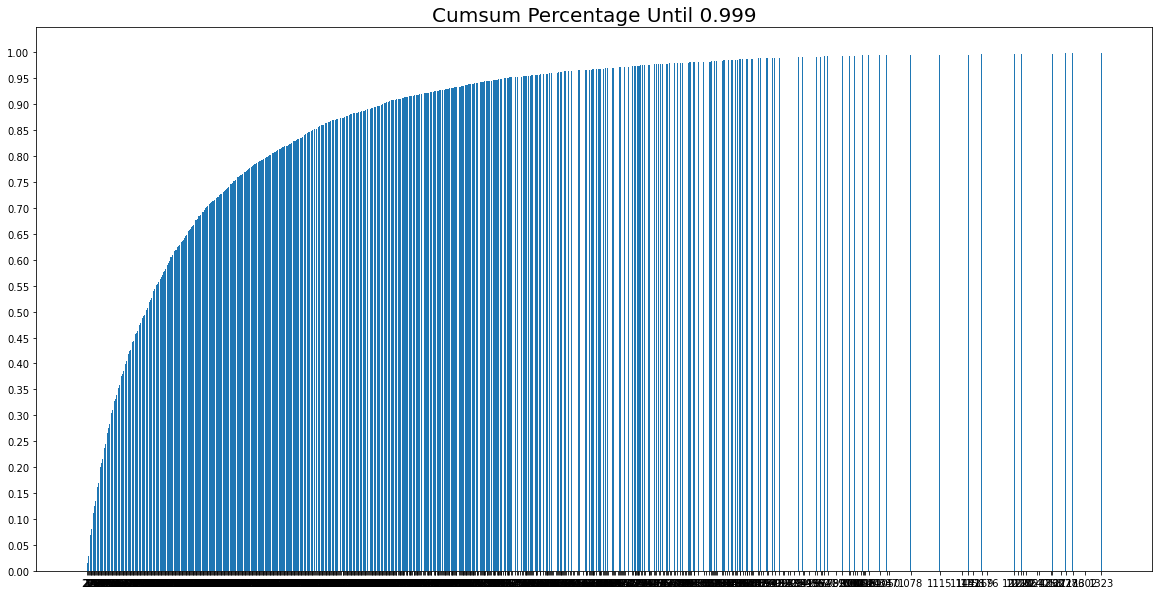

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999)
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time

초단위의 시간 계산을 연/월/일 형태로 변경하여 줍니다. [(참고자료)](https://ichi.pro/ko/python-eseo-naljja-mich-sigan-eul-cheolihaneun-5-dangye-77747529744229)

In [14]:
from datetime import datetime

data['Time'] = data['Time'].map(lambda x: datetime.utcfromtimestamp(x))
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [15]:
# Time 데이터에서 가장 오래된 날짜, 최근 날짜를 확인
oldset, latest = data['Time'].min(), data['Time'].max()
print(oldset)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [16]:
year_ago = latest - dt.timedelta(365)  # 최종 날짜로부터 1년 전 날짜를 구한다.
year_ago

Timestamp('2002-02-28 17:49:50')

In [17]:
data = data[data['Time'] > year_ago]  # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time
5170,36,1387,5,2002-03-12 03:46:59
5267,36,1201,4,2002-03-12 03:46:59
5122,36,1291,5,2002-03-12 03:47:16
5123,36,2167,5,2002-03-12 03:48:25
5290,36,2951,4,2002-03-12 03:48:25
...,...,...,...,...
992358,5996,3835,3,2002-04-29 20:46:24
992279,5996,2422,3,2002-04-29 20:47:05
992702,5996,168,3,2002-09-03 13:12:26
992459,5996,339,4,2002-10-07 13:24:39


In [18]:
oldset, latest = data['Time'].min(), data['Time'].max()
print(oldset)
print(latest)

2002-02-28 19:06:39
2003-02-28 17:49:50


### Data Cleansing

In [19]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [20]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
5170,36,1387,5,2002-03-12 03:46:59
5267,36,1201,4,2002-03-12 03:46:59
5122,36,1291,5,2002-03-12 03:47:16
5123,36,2167,5,2002-03-12 03:48:25
5290,36,2951,4,2002-03-12 03:48:25
...,...,...,...,...
992358,5996,3835,3,2002-04-29 20:46:24
992279,5996,2422,3,2002-04-29 20:47:05
992702,5996,168,3,2002-09-03 13:12:26
992459,5996,339,4,2002-10-07 13:24:39


### Train/Valid/Test split

train/valid/test 데이터의 기간이 겹치지 않게 하기 위해 아래와 같이 날짜 데이터를 나눠주겠습니다.

- train : 직전 1개년 데이터 중 1~10번째 월 데이터 
- valid : 직년 1개년 데이터 중 11번째 월 데이터
- test : 직년 1개년 데이터 중 12번째 월 데이터

기존 실습에서 사용하였던 함수와 코드를 사용하여 데이터를 split하려 하였으나 계속 데이터 기간이 겹치는 결과가 발생해, 아래와 같이 새로운 코드로 기간이 겹치지 않게 해주었습니다.

In [21]:
# train data 기간 설정
train_begin = latest - dt.timedelta(60)
train = data[data['Time'] < train_begin]
train

,UserId,ItemId,Rating,Time
5170,36,1387,5,2002-03-12 03:46:59
5267,36,1201,4,2002-03-12 03:46:59
5122,36,1291,5,2002-03-12 03:47:16
5123,36,2167,5,2002-03-12 03:48:25
5290,36,2951,4,2002-03-12 03:48:25
...,...,...,...,...
992358,5996,3835,3,2002-04-29 20:46:24
992279,5996,2422,3,2002-04-29 20:47:05
992702,5996,168,3,2002-09-03 13:12:26
992459,5996,339,4,2002-10-07 13:24:39


In [22]:
# test data 기간 설정
test_begin = latest - dt.timedelta(30)
test = data[data['Time'] > test_begin]
test

,UserId,ItemId,Rating,Time
28225,195,2808,3,2003-02-02 21:08:38
27759,195,1254,4,2003-02-06 17:23:42
28443,195,468,3,2003-02-11 17:42:36
28281,195,410,2,2003-02-11 18:23:28
28389,195,2791,3,2003-02-11 18:23:28
...,...,...,...,...
984731,5950,3948,4,2003-02-27 18:13:57
984682,5950,3578,4,2003-02-27 18:14:30
984475,5950,3793,3,2003-02-27 18:15:10
984660,5950,3555,2,2003-02-27 18:15:37


In [23]:
# valid data 기간 설정
valid_data = (data['Time'] > train_begin) & (data['Time'] < test_begin)  # 변수에 담기
valid = data[valid_data]  # 담은 변수를 data[]으로 감싸주기
valid

,UserId,ItemId,Rating,Time
8704,59,2997,4,2003-01-07 18:02:48
8781,59,2369,4,2003-01-07 18:04:24
8797,59,3408,4,2003-01-07 18:04:52
8808,59,2712,3,2003-01-07 18:04:52
8809,59,2716,3,2003-01-07 18:05:31
...,...,...,...,...
983989,5948,224,4,2003-01-20 13:07:52
984167,5948,1283,5,2003-01-20 13:10:49
984206,5948,1304,5,2003-01-20 13:14:16
984173,5948,1288,4,2003-01-20 13:15:09


In [24]:
# data에 대한 정보를 살펴 봅시다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [25]:
stats_info(train, 'train')
stats_info(valid, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 15675
	 Sessions: 442
	 Items: 1525
	 First Time : 2002-02-28 19:06:39
	 Last Time : 2002-12-30 16:54:04

* valid Set Stats Info
	 Events: 1581
	 Sessions: 132
	 Items: 921
	 First Time : 2002-12-30 18:21:02
	 Last Time : 2003-01-29 17:00:13

* test Set Stats Info
	 Events: 1367
	 Sessions: 96
	 Items: 835
	 First Time : 2003-01-29 19:36:56
	 Last Time : 2003-02-28 17:49:50



train, valid, test 데이터의 기간이 겹치지 않고 잘 분류된 것을 확인할 수 있습니다.

In [26]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱한다
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해준다.
    return df

train = indexing(train, id2idx)
valid = indexing(valid, id2idx)
test = indexing(test, id2idx)

In [27]:
# 데이터 저장하기
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
valid.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Data Pipeline

실습을 통해 배웠던 Session-Parallel Mini-Batch를 다시 한번 구현하겠습니다.

### Session Dataset

In [28]:
# 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.  

In [29]:
tr_dataset = SessionDataset(train)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,2002-03-12 03:46:59,0
5267,36,1201,4,2002-03-12 03:46:59,1
5122,36,1291,5,2002-03-12 03:47:16,2
5123,36,2167,5,2002-03-12 03:48:25,3
5290,36,2951,4,2002-03-12 03:48:25,4
5359,36,2115,5,2002-03-12 03:48:25,5
5073,36,1912,5,2002-03-12 03:48:44,6
5113,36,2662,3,2002-03-12 03:48:44,7
5366,36,2985,4,2002-03-12 03:49:01,8
5145,36,198,5,2002-03-12 03:49:48,9


In [30]:
# click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있습니다.
tr_dataset.click_offsets

array([    0,    30,    37,   119,   131,   136,   138,   179,   181,
         202,   208,   225,   239,   250,   299,   368,   380,   461,
         538,   650,   691,   726,   731,   733,   753,   762,   772,
         778,   782,   864,   945,   947,   950,   987,  1016,  1502,
        1508,  1529,  1639,  1640,  1648,  1678,  1693,  1708,  1723,
        1780,  1782,  1831,  1908,  1915,  1940,  1944,  1946,  2089,
        2095,  2101,  2146,  2154,  2312,  2322,  2362,  2366,  2374,
        2376,  2378,  2380,  2396,  2454,  2457,  2498,  2537,  2550,
        2554,  2555,  2592,  2602,  2603,  2612,  2960,  3029,  3059,
        3112,  3225,  3275,  3287,  3299,  3305,  3429,  3446,  3454,
        3457,  3461,  3963,  3982,  4013,  4027,  4032,  4088,  4090,
        4114,  4117,  4123,  4132,  4166,  4174,  4177,  4221,  4233,
        4320,  4350,  4352,  4358,  4372,  4409,  4434,  4468,  4567,
        4625,  4660,  4705,  4716,  4857,  4861,  4909,  5017,  5020,
        5037,  5047,

In [31]:
# session_idx 변수는 각 세션을 인덱싱한 np.array 입니다.
tr_dataset.session_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

### SessionDataLoader

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.  
__ iter __ 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield합니다.  
mask는 후에 RNN Cell State를 초기화 하는데 사용할 것입니다.

In [32]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [33]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,2002-03-12 03:46:59,0
5267,36,1201,4,2002-03-12 03:46:59,1
5122,36,1291,5,2002-03-12 03:47:16,2
5123,36,2167,5,2002-03-12 03:48:25,3
5290,36,2951,4,2002-03-12 03:48:25,4
5359,36,2115,5,2002-03-12 03:48:25,5
5073,36,1912,5,2002-03-12 03:48:44,6
5113,36,2662,3,2002-03-12 03:48:44,7
5366,36,2985,4,2002-03-12 03:49:01,8
5145,36,198,5,2002-03-12 03:49:48,9


In [34]:
iter_ex = iter(tr_data_loader)

In [35]:
# 실행 시 next가 계속 다음 데이터를 만듭니다.
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 30 37 37]
Label Item Idx are :       [  1  31  38 113]
Previous Masked Input Idx are []


## Modeling

### Evaluation Metric

모델 성능에 대한 지표로 precision이나 recall이 있습니다.
Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.
이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다. [참고자료1](https://zzaebok.github.io/recommender_system/metrics/rec_metrics/), [참고자료2](https://shate-programming.tistory.com/64)

In [36]:
# mrr
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

# recall@k 지표
def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [38]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    
    return model

In [39]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리합니다.
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, valid, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [40]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 1525)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      236550    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 1525)                77775     
Total params: 314,325
Trainable params: 314,325
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [41]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [42]:
train_model(model, args)

Train:   0%|          | 0/238 [00:00<?, ?it/s, accuracy=0, train_loss=7.12]     

	 - Recall@20 epoch 1: 0.050781
	 - MRR@20    epoch 1: 0.007774



Train:   0%|          | 0/238 [00:00<?, ?it/s, accuracy=0, train_loss=7.04]     

	 - Recall@20 epoch 2: 0.046875
	 - MRR@20    epoch 2: 0.007233



Train:   0%|          | 0/238 [00:00<?, ?it/s, accuracy=0, train_loss=7.07]     

	 - Recall@20 epoch 3: 0.039062
	 - MRR@20    epoch 3: 0.006754



Train:   0%|          | 0/238 [00:00<?, ?it/s, accuracy=0, train_loss=6.99]     

	 - Recall@20 epoch 4: 0.039062
	 - MRR@20    epoch 4: 0.008862



Train:   0%|          | 0/238 [00:00<?, ?it/s, accuracy=0, train_loss=6.96]     

	 - Recall@20 epoch 5: 0.031250
	 - MRR@20    epoch 5: 0.011583



Train:   0%|          | 0/238 [00:00<?, ?it/s, accuracy=0, train_loss=6.93]     

	 - Recall@20 epoch 6: 0.035156
	 - MRR@20    epoch 6: 0.011561



Train:   0%|          | 0/238 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.92]

	 - Recall@20 epoch 7: 0.039062
	 - MRR@20    epoch 7: 0.008307



Train:   0%|          | 0/238 [00:00<?, ?it/s, accuracy=0, train_loss=6.88]     

	 - Recall@20 epoch 8: 0.039062
	 - MRR@20    epoch 8: 0.009366



Train:   0%|          | 0/238 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.77]

	 - Recall@20 epoch 9: 0.046875
	 - MRR@20    epoch 9: 0.011252



Evaluation:  18%|█▊        | 4/22 [00:01<00:07,  2.41it/s]

	 - Recall@20 epoch 10: 0.039062
	 - MRR@20    epoch 10: 0.010474



### Inference

In [43]:
# 지금까지 학습한 모델이 테스트셋에 대해서도 유사한 수준의 성능을 내는지 검증해 봅시다.
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   5%|▌         | 1/19 [00:00<00:07,  2.34it/s]

	 - Recall@20: 0.062500
	 - MRR@20: 0.006064



## 세션 변경

- 직전 1개년이 아닌 전체 데이터를 대상으로 평점 데이터가 4점 이상인 데이터만 사용하기

In [44]:
data2 = load_data(train_path, None)
data2.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data2

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [45]:
data2['Time'] = data2['Time'].map(lambda x: datetime.utcfromtimestamp(x))
data2

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [46]:
oldset, latest = data2['Time'].min(), data2['Time'].max()
print(oldset)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [47]:
latest - oldset

Timedelta('1038 days 18:44:18')

In [48]:
year_ago = latest - dt.timedelta(1039)  # 전체 데이터를 사용한다.
year_ago

Timestamp('2000-04-25 17:49:50')

In [49]:
data2 = data2[data2['Time'] > year_ago]  # 방금 구한 날짜 이후의 데이터만 모은다. 
data2

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [50]:
# 평점 4점이상만 사용하기
data2 = data2[data2['Rating'] > 3]
data2.shape

(575281, 4)

- train : 직전 1개년 데이터 중 1~10번째 월 데이터 
- valid : 직년 1개년 데이터 중 11번째 월 데이터
- test : 직년 1개년 데이터 중 12번째 월 데이터

In [51]:
train_begin = latest - dt.timedelta(180)
train = data2[data2['Time'] < train_begin]
train

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
36,1,1836,5,2000-12-31 22:02:52
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04


In [52]:
test_begin = latest - dt.timedelta(90)
test = data2[data2['Time'] > test_begin]
test

,UserId,ItemId,Rating,Time
5200,36,2269,5,2002-12-22 08:05:50
5256,36,1701,4,2002-12-22 08:05:50
5364,36,3786,4,2002-12-22 08:08:41
5262,36,2369,4,2002-12-22 08:09:24
5280,36,3174,4,2002-12-22 08:11:25
...,...,...,...,...
984713,5950,3911,4,2003-02-27 18:03:46
984544,5950,3481,4,2003-02-27 18:04:50
984731,5950,3948,4,2003-02-27 18:13:57
984682,5950,3578,4,2003-02-27 18:14:30


In [53]:
valid_data = (data2['Time'] > train_begin) & (data2['Time'] < test_begin)  # 변수에 담기
valid = data2[valid_data]  # 담은 변수를 data[]으로 감싸주기
valid

,UserId,ItemId,Rating,Time
9676,65,2194,5,2002-09-29 21:33:17
21700,157,3753,4,2002-10-11 16:42:02
21434,157,912,5,2002-10-11 16:53:02
21533,157,3196,5,2002-10-11 16:53:02
21604,157,1944,4,2002-10-11 16:53:02
...,...,...,...,...
959090,5787,2706,4,2002-10-05 19:58:29
958774,5787,3096,4,2002-10-05 19:58:47
969105,5841,1965,4,2002-10-17 11:37:08
983995,5948,2804,5,2002-10-15 00:43:24


In [54]:
stats_info(train, 'train')
stats_info(valid, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 570482
	 Sessions: 6036
	 Items: 3531
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-01 04:20:59

* valid Set Stats Info
	 Events: 2266
	 Sessions: 207
	 Items: 1108
	 First Time : 2002-09-01 19:43:16
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 2533
	 Sessions: 207
	 Items: 1198
	 First Time : 2002-11-30 20:24:52
	 Last Time : 2003-02-28 17:49:50



In [55]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱한다
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해준다.
    return df

train = indexing(train, id2idx)
valid = indexing(valid, id2idx)
test = indexing(test, id2idx)

In [56]:
# 데이터 저장하기
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
valid.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [57]:
tr_dataset = SessionDataset(train)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
36,1,1836,5,2000-12-31 22:02:52,4
3,1,3408,4,2000-12-31 22:04:35,5
7,1,2804,5,2000-12-31 22:11:59,6
47,1,1207,4,2000-12-31 22:11:59,7
0,1,1193,5,2000-12-31 22:12:40,8
44,1,260,4,2000-12-31 22:12:40,9


In [58]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
36,1,1836,5,2000-12-31 22:02:52,4
3,1,3408,4,2000-12-31 22:04:35,5
7,1,2804,5,2000-12-31 22:11:59,6
47,1,1207,4,2000-12-31 22:11:59,7
0,1,1193,5,2000-12-31 22:12:40,8
44,1,260,4,2000-12-31 22:12:40,9


In [59]:
args = Args(train, valid, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [60]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 3531)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      537450    
_________________________________________________________________
dropout_1 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (64, 3531)                180081    
Total params: 717,531
Trainable params: 717,531
Non-trainable params: 0
_________________________________________________________________


In [61]:
train_model(model, args)

Train:   0%|          | 0/8819 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.71]

	 - Recall@20 epoch 1: 0.107143
	 - MRR@20    epoch 1: 0.022187



Train:   0%|          | 0/8819 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.41]

	 - Recall@20 epoch 2: 0.132812
	 - MRR@20    epoch 2: 0.030722



Train:   0%|          | 0/8819 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.24]

	 - Recall@20 epoch 3: 0.147321
	 - MRR@20    epoch 3: 0.031625



Train:   0%|          | 0/8819 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.18]

	 - Recall@20 epoch 4: 0.138393
	 - MRR@20    epoch 4: 0.027484



Train:   0%|          | 0/8819 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.15]

	 - Recall@20 epoch 5: 0.139509
	 - MRR@20    epoch 5: 0.030911



Train:   0%|          | 0/8819 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.06]

	 - Recall@20 epoch 6: 0.143973
	 - MRR@20    epoch 6: 0.032699



Train:   0%|          | 0/8819 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.04]

	 - Recall@20 epoch 7: 0.142857
	 - MRR@20    epoch 7: 0.034102



Train:   0%|          | 0/8819 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.16]

	 - Recall@20 epoch 8: 0.146205
	 - MRR@20    epoch 8: 0.034320



Train:   0%|          | 0/8819 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.01]

	 - Recall@20 epoch 9: 0.145089
	 - MRR@20    epoch 9: 0.032830



Evaluation:  44%|████▍     | 14/32 [00:05<00:07,  2.42it/s]

	 - Recall@20 epoch 10: 0.147321
	 - MRR@20    epoch 10: 0.030674



In [62]:
test_model(model, args, test)

Evaluation:  36%|███▌      | 13/36 [00:05<00:09,  2.46it/s]

	 - Recall@20: 0.143029
	 - MRR@20: 0.048124



## 하이퍼 파라미터 변경

- 모델 학습 시 batch_size가 클 경우 인덱스 에러가 발생하는 경우가 있어, batch_size를 절반으로 더 줄여보았다.

In [63]:
args = Args(train, valid, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [64]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(32, 1, 3531)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      537450    
_________________________________________________________________
dropout_2 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (32, 3531)                180081    
Total params: 717,531
Trainable params: 717,531
Non-trainable params: 0
_________________________________________________________________


In [65]:
train_model(model, args)

Train:   0%|          | 0/17638 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.08]

	 - Recall@20 epoch 1: 0.125000
	 - MRR@20    epoch 1: 0.032470



Train:   0%|          | 0/17638 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.89]

	 - Recall@20 epoch 2: 0.130335
	 - MRR@20    epoch 2: 0.035356



Train:   0%|          | 0/17638 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.8] 

	 - Recall@20 epoch 3: 0.138720
	 - MRR@20    epoch 3: 0.037152



Train:   0%|          | 0/17638 [00:00<?, ?it/s, accuracy=0, train_loss=5.86]     

	 - Recall@20 epoch 4: 0.141006
	 - MRR@20    epoch 4: 0.038537



Train:   0%|          | 0/17638 [00:00<?, ?it/s, accuracy=0, train_loss=5.74]     

	 - Recall@20 epoch 5: 0.149390
	 - MRR@20    epoch 5: 0.040018



Train:   0%|          | 0/17638 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.65]

	 - Recall@20 epoch 6: 0.150152
	 - MRR@20    epoch 6: 0.041739



Train:   0%|          | 0/17638 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.56]

	 - Recall@20 epoch 7: 0.147104
	 - MRR@20    epoch 7: 0.042279



Train:   0%|          | 0/17638 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.61]

	 - Recall@20 epoch 8: 0.145579
	 - MRR@20    epoch 8: 0.039864



Train:   0%|          | 0/17638 [00:00<?, ?it/s, accuracy=0, train_loss=5.59]     

	 - Recall@20 epoch 9: 0.149390
	 - MRR@20    epoch 9: 0.041817



Evaluation:  64%|██████▍   | 41/64 [00:08<00:04,  4.63it/s]

	 - Recall@20 epoch 10: 0.147104
	 - MRR@20    epoch 10: 0.041643



In [66]:
test_model(model, args, test)

Evaluation:  56%|█████▌    | 40/72 [00:08<00:06,  4.62it/s]

	 - Recall@20: 0.163281
	 - MRR@20: 0.055327



# 회고

### 어려웠던 부분

1) 인덱스 에러 발생
- 모델 학습 단계에서 batch size 크기와 관련되었던 문제였다. batch size를 줄여주니 그 이후부터는 인덱스 에러가 발생하지 않았다.

2) 모델구조 변경
- 루브릭에서 모델구조에 대한 변화는 어떻게 해줘야 할지 잘몰라 세션 데이터 변경과 하이파라미터 변경만 진행하였다

3) Time 데이터 활용 관련
- Time 데이터를 전처리 해주지 않고 모델 학습을 진행할 수 도 있었으나, 초단위로 되어 있어 데이터를 파악하는데 직관적이지 않아서 연/월/일/시간 형태로 변환해주어 진행하였다.  


- Time data split 과정에서 기존 실습 코드를 사용해 데이터를 나누어주었을 때 train, valid, test 데이터가 섞여서 split되어 다른 분의 커널을 참고해 원하는 대로 데이터를 split할 수 있었다. 

### 새롭게 알게 된 부분

1) 데이터셋에 SessionID 대신 UserID 항목이 들어갔다는 점
- User id를 SessionId와 동일하게 간주하고 학습을 시켰는데, 다른 분들은 어떻게 하나 참고해보니 UserID와 Time의 교집합을 이용하여 새로운 SessionID 컬럼을 추가해주어 진행하는 경우도 있었다.  

  
- 이 부분에 대해서 동일한 User ID를 기준으로 time별로 나누게 되면 오히려 session이 너무 많이 쪼개지는 것이 아닌가? 라는 의문이 든다.  


- 아래 데이터와 같이 User Id가 1인 사용자에 대한 일자별 session을 나눌 수 있다면 좀 더 정확한 예측이 가능하지 않을까 생각된다.

In [7]:
data[data['UserId'] == 1]

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
36,1,1836,5,978300172
3,1,3408,4,978300275
7,1,2804,5,978300719
47,1,1207,4,978300719
0,1,1193,5,978300760


2) 추천시스템에서 사용되는 metrics(Rank-less, Rank-aware recommendation metrics)

3) Session_length를 구하는 부분에서 groupby.size()를 사용하면서 groupby.count(),
data['컬럼명'].value_counts() 와 차이점이 궁금해졌는데 이 부분을 구글링을 통해 다시 되짚어보게 되었다.